# Space objects practice|

In [88]:
import json
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [89]:
ORIGINAL_PATH = 'data_original.csv'
FILTRATED_PATH = 'data_filtrated.csv'
INPUT_PATH = 'data_input.csv'
PREDICTED_PATH = 'data_predicted.csv'

In [90]:
df_orig = pd.read_csv(ORIGINAL_PATH)

In [91]:
df_filt = df_orig.drop(columns=['Row_id', 'rerun_ID'])

In [92]:
class_labels = {'GALAXY': 0, 'STAR': 1, 'QSO': 2}
reversed_labels = dict(zip(class_labels.values(), class_labels.keys()))

In [93]:
df_filt['class'] = df_filt['class'].replace(class_labels)

/tmp/ipykernel_19336/3680863032.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_filt['class'] = df_filt['class'].replace(class_labels)


In [94]:
df_filt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89999 entries, 0 to 89998
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   obj_ID       89999 non-null  float64
 1   alpha        89999 non-null  float64
 2   delta        89999 non-null  float64
 3   u            89999 non-null  float64
 4   g            89999 non-null  float64
 5   r            89999 non-null  float64
 6   i            89999 non-null  float64
 7   z            89999 non-null  float64
 8   run_ID       89999 non-null  int64  
 9   cam_col      89999 non-null  int64  
 10  field_ID     89999 non-null  int64  
 11  spec_obj_ID  89999 non-null  float64
 12  class        89999 non-null  int64  
 13  redshift     89999 non-null  float64
 14  plate        89999 non-null  int64  
 15  MJD          89999 non-null  int64  
 16  fiber_ID     89999 non-null  int64  
dtypes: float64(10), int64(7)
memory usage: 11.7 MB


In [95]:
class_data = {}
for class_label in class_labels:
    class_data[class_label] = df_filt[df_filt['class'] == class_labels[class_label]]

In [96]:
for class_label in class_labels:
    X = class_data[class_label].drop(columns=['class'])
    clf = LocalOutlierFactor(n_neighbors=30, contamination=0.08)
    y_pred = clf.fit_predict(X)
    anomalies = X[y_pred == -1]
    print(f"Anomalies in class {class_label}:")
    print(anomalies)
    df_filt = df_filt[~df_filt.index.isin(anomalies.index)]

Anomalies in class GALAXY:
             obj_ID       alpha      delta         u         g         r  \
41     1.237671e+18  146.925784  14.880037  25.52618  22.45513  21.82048   
49     1.237661e+18  129.628095  29.059057  24.91692  21.27143  19.59078   
61     1.237662e+18  252.654652  19.732789  25.19646  21.77507  20.79209   
67     1.237662e+18  252.410933  19.757336  22.08841  19.65585  18.15532   
90     1.237668e+18  160.056573  23.004922  20.64593  19.19186  18.71879   
...             ...         ...        ...       ...       ...       ...   
89870  1.237662e+18  221.759785  45.501951  26.20675  24.16119  21.79150   
89918  1.237652e+18  207.346069   1.191146  24.74869  21.87063  20.42504   
89919  1.237652e+18  207.747789   1.156031  22.39501  21.30981  19.47198   
89952  1.237668e+18  239.595627  11.692894  18.87798  17.54985  16.86987   
89957  1.237664e+18  136.677235   9.080618  22.58019  22.25608  20.59716   

              i         z  run_ID  cam_col  field_ID   spec_

In [97]:
df_filt = df_filt.reset_index(drop=True)

In [98]:
def show_statistics(df):
    grouped_data = df.groupby('class')

    num_columns = len(df.columns) - 1
    num_rows = int(np.ceil(num_columns / 2))
    fig, axs = plt.subplots(num_rows, 2, figsize=(10, 5 * num_rows))

    for i, column in enumerate(df.columns[1:]):
        row = i // 2
        col = i % 2
        ax = axs[row, col]
        
        for class_label, class_data in grouped_data:
            sns.histplot(data=class_data, x=column, label=class_label, ax=ax)
        
        ax.set_xlabel(column)
        ax.set_ylabel('Density')
        ax.legend()

    plt.tight_layout()

    plt.show()

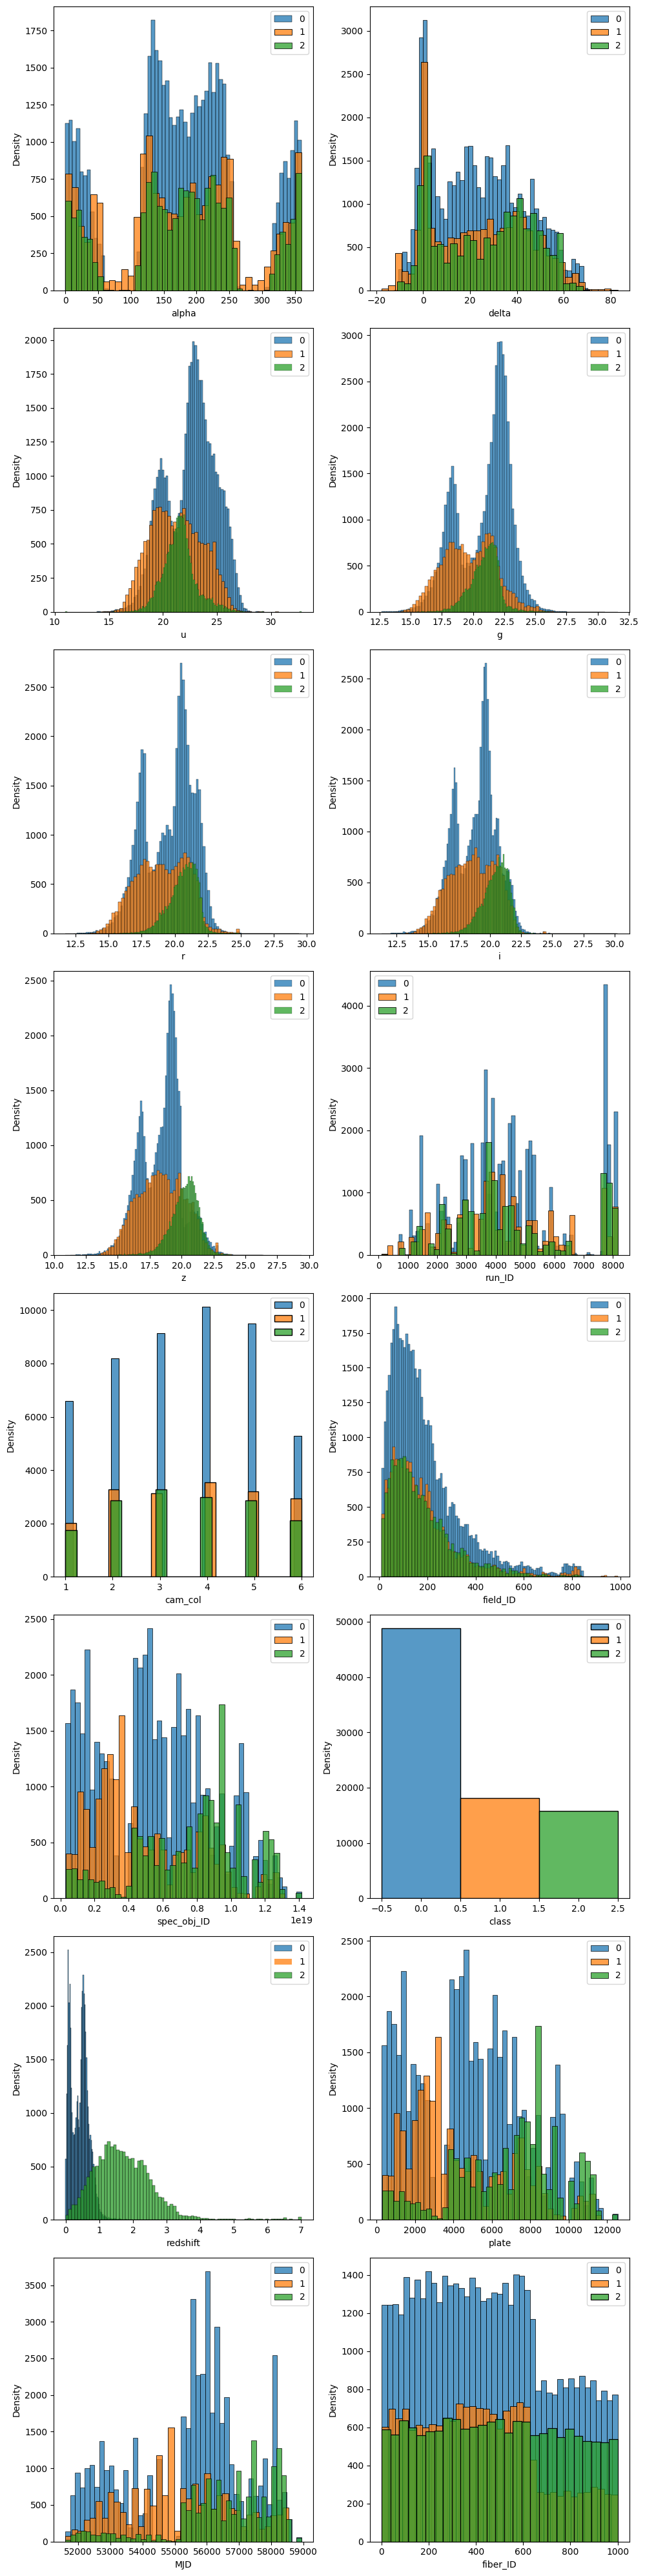

In [99]:
show_statistics(df_filt)

In [100]:
df_filt.to_csv(FILTRATED_PATH, index=False)

In [101]:
model = LGBMClassifier()

In [102]:
scaler = StandardScaler()

In [103]:
X_train, X_test, y_train, y_test = train_test_split(
    df_filt.drop(columns=['class']), df_filt['class'], test_size=0.15, random_state=42
    )

In [104]:
scaler.fit(X_train)

StandardScaler()

In [105]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [106]:
hyperparams = {
    'verbosity': [-1],
    'num_class': [3],
    'num_leaves': [62, 127],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [50, 200],
    'max_depth': [-1]
}

In [107]:
space = {
    'learning_rate': hp.choice('learning_rate', np.arange(0.001, 0.41, 0.001)),
    'num_leaves': hp.choice('num_leaves', np.arange(4, 2056, 1)),
    'max_depth': hp.choice('max_depth', [-1, 6, 12, 20, 32]),
    'min_data_in_leaf': hp.choice('min_data_in_leaf', np.arange(3, 256, 2)),
    'bagging_fraction': hp.choice('bagging_fraction', np.arange(0.1, 1.00, 0.05)),
    'feature_fraction': hp.choice('feature_fraction', np.arange(0.1, 1.00, 0.05)),
    'lambda_l1': hp.choice('lambda_l1', np.arange(0.0, 10.1, 0.1)),
    'lambda_l2': hp.choice('lambda_l2', np.arange(0.0, 10.1, 0.1)),
    'min_gain_to_split': hp.choice('min_gain_to_split', np.arange(0.0, 4.0, 0.1)),
    'bagging_freq': hp.choice('bagging_freq', np.arange(0, 5)),
    'boosting': hp.choice('boosting', ['gbdt', 'dart'])
}

In [108]:
def objective(params):
    model = LGBMClassifier(verbosity=-1, num_class=3,**params)
    model.fit(X_train_scaled, y_train)
    score = model.score(X_test_scaled, y_test)
    return {'loss': -score, 'status': STATUS_OK}

In [109]:
trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

100%|██████████| 100/100 [03:22<00:00,  2.02s/trial, best loss: -0.9777777777777777]


In [110]:
best_params_copy = best_params.copy()

In [ ]:
with open('best_params.json', 'w') as f:
    json.dump({k: int(v.item()) for k, v in best_params.items()}, f)

# Testing

In [ ]:
with open('best_params.json', 'r') as f:
    best_params = json.load(f)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_filt.drop(columns=['class']), df_filt['class'], test_size=0.2, random_state=42, stratify=df_filt['class']
)

In [ ]:
model = LGBMClassifier(num_class=3, **best_params)
model.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] lambda_l2 is set=69, reg_lambda=0.0 will be ignored. Current value: lambda_l2=69
[LightGBM] [Warning] min_gain_to_split is set=9, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9
[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] lambda_l2 is set=69, reg_lambda=0.0 will be ignored. Current value: lambda_l2=69
[LightGBM] [Warning] min_gain_to_split is set=9, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9
[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2
[Light

LGBMClassifier(bagging_freq=2, lambda_l1=2, lambda_l2=69, learning_rate=218,
               max_depth=3, min_data_in_leaf=67, min_gain_to_split=9,
               num_class=3, num_leaves=585)

In [ ]:
y_pred = model.predict(X_test)

[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] lambda_l2 is set=69, reg_lambda=0.0 will be ignored. Current value: lambda_l2=69
[LightGBM] [Warning] min_gain_to_split is set=9, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9
[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


In [ ]:
y_test

23371    1
50192    2
62180    0
79795    0
2456     1
        ..
24548    0
832      0
62517    0
46027    0
73425    0
Name: class, Length: 16560, dtype: int64

In [ ]:
y_pred

array([1, 2, 0, ..., 0, 0, 0])

In [ ]:
accuracy = accuracy_score(y_test, y_pred)

In [ ]:
print(f"Accuracy: {accuracy}")

Accuracy: 0.9588164251207729


In [ ]:
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Inputs

In [ ]:
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

In [ ]:
df_input = pd.read_csv(INPUT_PATH)

In [ ]:
df_input_copy = df_input

In [113]:
df_input = df_input.assign(new_column=pd.Series([], dtype='object'))

In [114]:
df_input.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID,new_column
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,2,79,6.543777e+18,0,0.634794,5812,56354,171,NaN
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,5,119,1.176014e+19,0,0.779136,10445,58158,427,NaN
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,2,120,5.152200e+18,0,0.644195,4576,55592,299,NaN
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,3,214,1.030107e+19,0,0.932346,9149,58039,775,NaN
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,3,137,6.891865e+18,0,0.116123,6121,56187,842,NaN


In [ ]:
df_input = df_input.drop(columns=['Row_id', 'rerun_ID'])

In [ ]:
df_input['class'] = df_input['class'].replace(class_labels)

/tmp/ipykernel_19336/1932384687.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_input['class'] = df_input['class'].replace(class_labels)


In [ ]:
df_input = df_input.reset_index(drop=True)

In [ ]:
df_input_scaled = scaler.transform(df_input.drop(columns=['class']))

In [ ]:
df_input_scaled = pd.DataFrame(df_input_scaled, columns=df_input.drop(columns=['class']).columns)

In [ ]:
df_input_scaled

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
0,-0.429292,-0.441389,0.427033,0.796964,0.802161,0.392781,0.032836,0.000435,-0.429193,-0.969581,-0.724769,0.228927,0.075731,0.228952,0.422021,-1.023582
1,0.032857,-0.346506,0.365091,1.197705,1.076542,1.577279,1.175774,1.600027,0.032764,0.937151,-0.457711,1.795918,0.272010,1.795930,1.415530,-0.084738
2,-0.429292,-0.373893,0.583748,1.414169,0.993727,0.508963,0.137199,0.088089,-0.429193,-0.969581,-0.451035,-0.189101,0.088515,-0.189090,0.002369,-0.554160
3,-0.132399,1.667206,-1.242608,0.020246,1.542247,1.050976,0.797011,0.259262,-0.132365,-0.334004,0.176551,1.357615,0.480347,1.357595,1.349993,1.191504
4,1.848149,1.735137,-0.147021,-1.183462,-1.512370,-1.715816,-1.787185,-1.842191,1.848173,-0.334004,-0.337535,0.333492,-0.629565,0.333462,0.330050,1.437217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4565,0.029818,0.359114,0.550637,1.708043,0.438197,0.102839,-0.033780,-0.113624,0.029725,0.937151,-0.604593,-0.431895,-0.153736,-0.431933,-0.173313,1.558240
4566,1.650474,1.574753,-1.170873,0.121536,0.999229,1.148969,1.438279,1.156586,1.650625,-1.605158,-0.397623,-0.316908,-0.272814,-0.316937,-0.059313,1.231845
4567,-0.621585,0.644073,1.078290,1.414339,0.355821,-0.048350,-0.309036,-0.385523,-0.621674,0.937151,-0.925062,0.303730,-0.079585,0.303698,0.265065,1.492228
4568,-0.621585,0.645884,1.074167,1.713005,1.577016,1.054211,0.732050,0.340440,-0.621674,0.937151,-0.918386,1.140084,0.311766,1.140119,1.269587,-1.280297


In [ ]:
y_pred = model.predict(df_input_scaled)

[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] lambda_l2 is set=69, reg_lambda=0.0 will be ignored. Current value: lambda_l2=69
[LightGBM] [Warning] min_gain_to_split is set=9, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9
[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


In [ ]:
y_pred

array([0, 0, 0, ..., 1, 0, 1])

In [ ]:
df_input_copy['class'] = y_pred

In [ ]:
df_input_copy['class'] = df_input_copy['class'].replace(reversed_labels)

In [ ]:
df_input_copy

,Row_id,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,2,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,3,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,4,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,5,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,STAR,0.116123,6121,56187,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4565,4566,1.237665e+18,212.775408,34.930049,25.92216,21.53700,19.85908,19.04902,18.59259,4512,301,5,97,4.343962e+18,STAR,0.466045,3858,55273,875
4566,4567,1.237679e+18,329.838089,1.010589,22.36399,22.67505,21.79275,21.62802,20.83235,7712,301,1,128,4.726744e+18,STAR,0.378475,4198,55480,786
4567,4568,1.237659e+18,240.216137,45.326555,25.26345,21.36990,19.57962,18.56678,18.11315,3226,301,5,49,6.792790e+18,STAR,0.520575,6033,56069,857
4568,4569,1.237659e+18,240.390570,45.245332,25.93329,23.84709,21.61760,20.39073,19.39324,3226,301,5,50,9.576933e+18,GALAXY,0.808372,8506,57893,101


In [ ]:
df_input_copy.to_csv(PREDICTED_PATH, index=False)